In [ ]:
import json
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer
from neo4j import GraphDatabase
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import torch
import numpy as np
from spacy import load as spacy_load
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import nltk

# Scarica risorse NLTK necessarie
nltk.download('vader_lexicon')

# Configurazione del modello SBERT e del tokenizzatore
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1').to(device)

# Inizializza strumenti per POS tagging e sentiment analysis
nlp = spacy_load("en_core_web_sm")
sentiment_analyzer = SentimentIntensityAnalyzer()

# Dizionari tematici
GENDER_TERMS = {"male", "female", "man", "woman", "she", "he"}
RELIGION_TERMS = {"christian", "muslim", "jewish", "buddhist"}
RACE_TERMS = {"black", "white", "hispanic", "asian"}
PROFESSION_TERMS = {"doctor", "teacher", "engineer", "nurse"}

class Neo4jHandler:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_entity_info_from_neo4j(self, term):
        query = """
        MATCH (n:Entity {id: $term})
        OPTIONAL MATCH (n)-[:INSTANCE_OF]->(instance)
        OPTIONAL MATCH (n)-[:SUBCLASS_OF]->(subclass)
        RETURN n.description AS description, collect(DISTINCT instance.id) AS instance_of, collect(DISTINCT subclass.id) AS subclass_of
        """
        with self.driver.session() as session:
            result = session.run(query, term=term).single()
        
        return {
            'description': result['description'] if result and result['description'] else "",
            'instance_of': result['instance_of'] if result and result['instance_of'] else [],
            'subclass_of': result['subclass_of'] if result and result['subclass_of'] else []
        }

@lru_cache(maxsize=None)
def get_embedding(text):
    embedding = embedding_model.encode(text, convert_to_tensor=True, device=device)
    return embedding

def extract_contextual_features(sentence):
    spacy_doc = nlp(sentence)
    
    # Conteggio POS
    pos_counts = Counter([token.pos_ for token in spacy_doc])
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)
    num_adjectives = pos_counts.get("ADJ", 0)
    
    # Sentiment Analysis
    sentiment_score = sentiment_analyzer.polarity_scores(sentence)['compound']
    
    # Lunghezza della frase
    word_count = len(sentence.split())
    
    # Identificazione dei termini tematici
    detected_bias = {
        "gender": any(token.lemma_.lower() in GENDER_TERMS for token in spacy_doc),
        "religion": any(token.lemma_.lower() in RELIGION_TERMS for token in spacy_doc),
        "race": any(token.lemma_.lower() in RACE_TERMS for token in spacy_doc),
        "profession": any(token.lemma_.lower() in PROFESSION_TERMS for token in spacy_doc)
    }
    
    # Caratteristiche binarie per ciascun dizionario tematico
    bias_features = [
        1 if detected_bias["gender"] else 0,
        1 if detected_bias["religion"] else 0,
        1 if detected_bias["race"] else 0,
        1 if detected_bias["profession"] else 0
    ]
    
    # Combina tutto
    return [num_nouns, num_verbs, num_adjectives, sentiment_score, word_count] + bias_features

def calculate_bias_score(sentence_embedding, stereotype_references, antistereotype_references, neutral_references):
    stereotype_similarity = max(util.cos_sim(sentence_embedding, emb).item() for emb in stereotype_references)
    antistereotype_similarity = max(util.cos_sim(sentence_embedding, emb).item() for emb in antistereotype_references)
    neutral_similarity = max(util.cos_sim(sentence_embedding, emb).item() for emb in neutral_references)
    bias_score = stereotype_similarity - antistereotype_similarity
    return bias_score, neutral_similarity

def get_batch_entity_info(terms, neo4j_handler):
    term_info = {}
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(neo4j_handler.get_entity_info_from_neo4j, terms))
        for term, result in zip(terms, results):
            term_info[term] = result
    return term_info

def enrich_with_multivectors(dataset, neo4j_handler, stereotype_refs, antistereotype_refs, neutral_refs, similarity_threshold=0.7):
    enriched_data = []
    description_cache = {}

    def process_item(item):
        context = item["Contesto"]
        sentence = item["Frase"]
        complete_sentence = sentence if "BLANK" in context else context + " " + sentence
        
        # Estrazione embedding principale
        context_embedding = get_embedding(complete_sentence)

        # Calcolo del bias score
        bias_score, neutral_similarity = calculate_bias_score(context_embedding, stereotype_refs, antistereotype_refs, neutral_refs)

        # Recupera parole chiave
        keywords = set(item["Soggetti"] + item["Oggetti"] + item["Sostantivi"] + item["Aggettivi"] + item["Avverbi"])
        term_info = get_batch_entity_info(keywords, neo4j_handler)

        # Calcola similarità e descrizioni rilevanti
        relevant_descriptions = []
        relevant_embeddings = []
        for term in keywords:
            entity_info = term_info.get(term)
            description = entity_info['description']
            if description:
                if term not in description_cache:
                    description_cache[term] = get_embedding(description)
                
                similarity = util.cos_sim(context_embedding, description_cache[term]).item()
                if similarity >= similarity_threshold:
                    relevant_descriptions.append(description)
                    relevant_embeddings.append(description_cache[term])

        # Creazione del multivettore combinato
        combined_embedding = torch.cat(
            [context_embedding] + relevant_embeddings if relevant_embeddings else [context_embedding]
        )

        # Estrazione caratteristiche contestuali
        contextual_features = torch.tensor(extract_contextual_features(complete_sentence), device=device, dtype=torch.float32)

        # Combina embedding e caratteristiche contestuali
        bias_tensor = torch.tensor([bias_score, neutral_similarity], device=device)
        combined_features = torch.cat([combined_embedding, contextual_features, bias_tensor])

        # Aggiunge il campo Multivettore al JSON
        item["Frase filtrata"] = {
            "Frase completa": {
                "Testo": complete_sentence,
                "Descrizioni rilevanti": relevant_descriptions,
                "Multivettore": combined_features.cpu().tolist()
            },
            "Bias Analysis": {
                "Bias Score": bias_score,
                "Neutral Similarity": neutral_similarity
            }
        }
        return item

    with ThreadPoolExecutor() as executor:
        enriched_data = list(executor.map(process_item, dataset))

    return enriched_data

# Frasi di riferimento
stereotype_references = [get_embedding(ref) for ref in ["The doctor is a man.", "The nurse is a woman."]]
antistereotype_references = [get_embedding(ref) for ref in ["The doctor is a woman.", "The nurse is a man."]]
neutral_references = [get_embedding(ref) for ref in ["The chess player was quick.", "The scientist was brilliant."]]

# Configurazione e connessione a Neo4j
neo4j_handler = Neo4jHandler("bolt://localhost:7687", "neo4j", "10086832")

# Carica il dataset e aggiunge i multivettori
stereoset_data = load_stereoset_from_file()
enriched_data = enrich_with_multivectors(
    stereoset_data,
    neo4j_handler,
    stereotype_references,
    antistereotype_references,
    neutral_references
)

# Salva il file JSON aggiornato
with open("stereoset_with_multivectors_and_bias.json", "w", encoding="utf-8") as file:
    json.dump(enriched_data, file, ensure_ascii=False, indent=4)

# Chiudi la connessione a Neo4j
neo4j_handler.close()
print("File 'stereoset_with_multivectors_and_bias.json' generato con successo.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danilogiovannico/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Caricamento del dataset...
Identificazione dei Bias Types...
Trovati Bias Types: ['race', 'profession', 'religion', 'gender']
Creazione del dataset bilanciato...
Pre-processing del dataset completo con PCA...
Dimensioni uniformi degli embedding: (12687, 3081)
PCA: Ridotto a 333 componenti per preservare il 95.0% della varianza
Applicazione padding e PCA al dataset bilanciato...
Standardizzazione delle embedding...
Esecuzione di clustering semi-supervisionato con GMM...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Risultati dei cluster salvati in cluster/gmm_semi_supervised_clusters.json
Clustering Accuracy: 0.3469
ARI (GMM): 0.0017
Silhouette Score (GMM): 0.3691
Clustering Accuracy (GMM): 0.3469


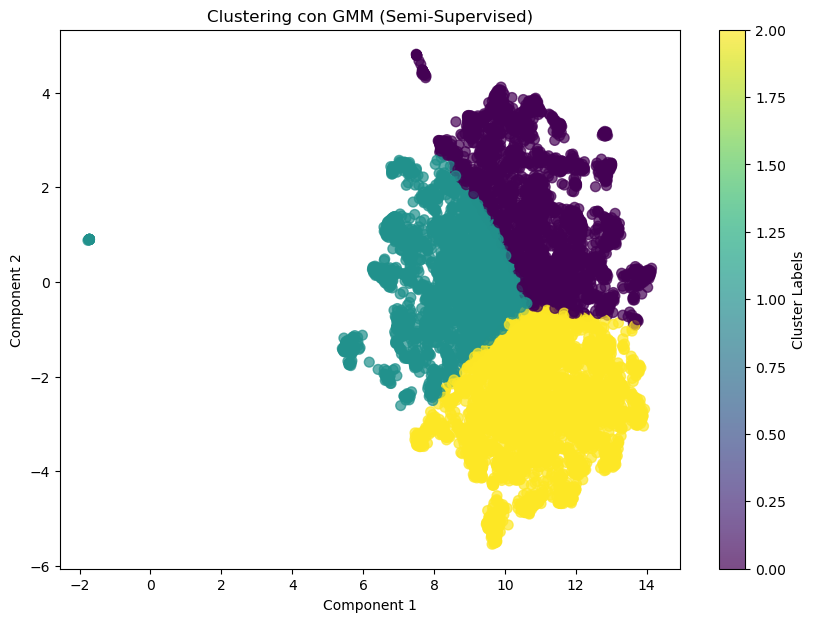

Esecuzione di clustering semi-supervisionato con HDBSCAN...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Risultati dei cluster salvati in cluster/hdbscan_semi_supervised_clusters.json
Clustering Accuracy: 0.2959
ARI (HDBSCAN): 0.0021
Silhouette Score (HDBSCAN): 0.1567


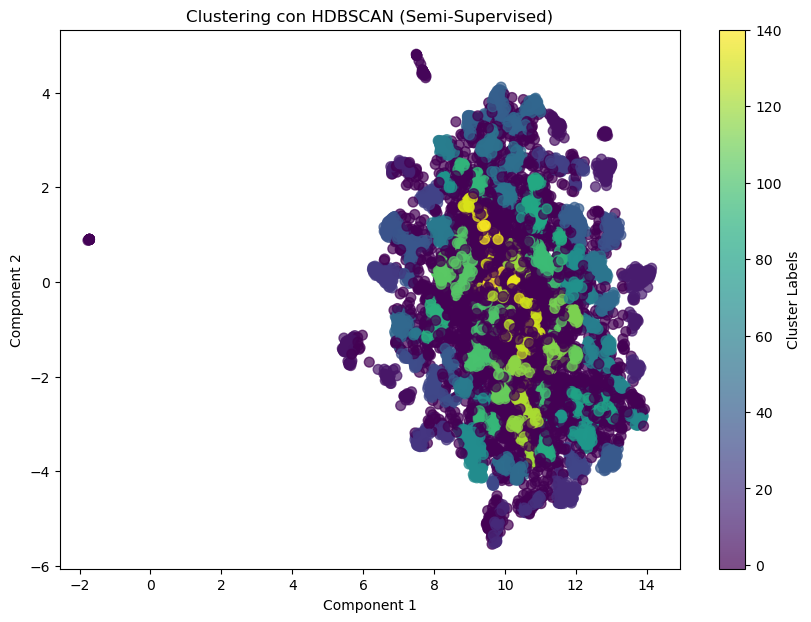

Esecuzione di clustering semi-supervisionato con KMeans...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Risultati dei cluster salvati in cluster/kmeans_semi_supervised_clusters.json
Clustering Accuracy: 0.3530
ARI (KMeans): 0.0043
Silhouette Score (KMeans): 0.3792


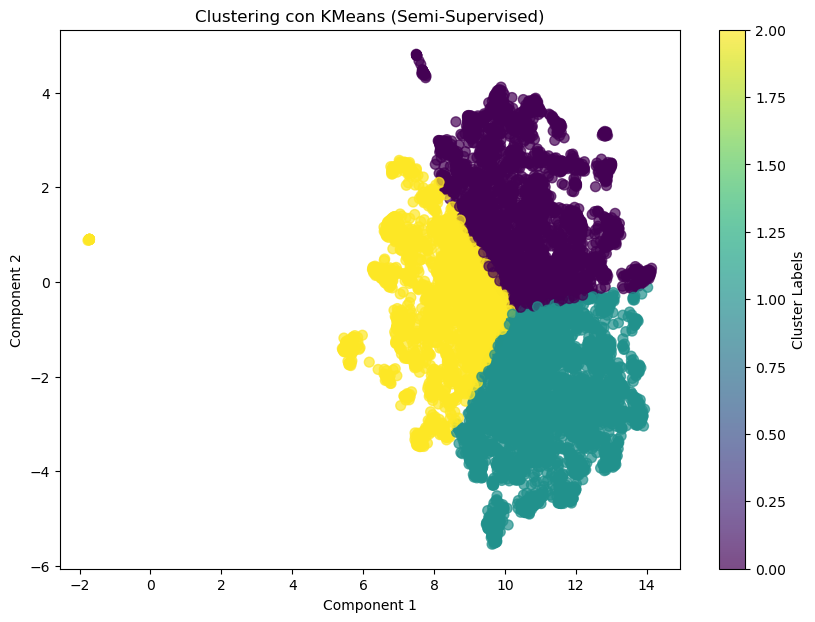

In [9]:
import json
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import hdbscan
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random

# Mappatura per Gold Label
label_mapping = {
    0: "STEREOTYPED",
    1: "ANTISTEREOTYPICAL",
    2: "NEUTRAL"
}

# Funzione per visualizzare i cluster
def plot_clusters(data, labels=None, title="Plot dei Cluster"):
    plt.figure(figsize=(10, 7))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label='Cluster Labels')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.show()

# Funzione per calcolare l'accuratezza della clusterizzazione
def compute_clustering_accuracy(cluster_labels, true_labels, documents, label_mapping, cluster_to_label):
    total = len(cluster_labels)
    correct = 0

    for i in range(total):
        cluster_label = cluster_to_label.get(cluster_labels[i], "NOISE")
        gold_label = label_mapping[true_labels[i]]
        if cluster_label == gold_label:
            correct += 1

    accuracy = correct / total
    print(f"Clustering Accuracy: {accuracy:.4f}")
    return accuracy

# Funzione per salvare i risultati e calcolare accuratezza
def save_clusters_and_compute_accuracy(documents, cluster_labels, true_labels, filename):
    cluster_to_label = {}
    for cluster_id in set(cluster_labels):
        if cluster_id == -1:  # Gestione dei punti rumorosi
            cluster_to_label[cluster_id] = "NOISE"
        else:
            cluster_indices = [i for i, c in enumerate(cluster_labels) if c == cluster_id]
            common_label = Counter([true_labels[i] for i in cluster_indices]).most_common(1)[0][0]
            cluster_to_label[cluster_id] = label_mapping[common_label]

    clusters = defaultdict(list)
    for doc, cluster_id in zip(documents, cluster_labels):
        cluster_label = cluster_to_label[cluster_id]
        clusters[cluster_label].append(doc)

    os.makedirs("cluster", exist_ok=True)
    filepath = os.path.join("cluster", filename)
    with open(filepath, "w") as file:
        json.dump(clusters, file, indent=4)
    print(f"Risultati dei cluster salvati in {filepath}")

    accuracy = compute_clustering_accuracy(cluster_labels, true_labels, documents, label_mapping, cluster_to_label)
    return accuracy

# Funzione per caricare il dataset
def load_dataset(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Funzione per bilanciare il dataset
def balance_dataset(data, bias_types, n_per_bias):
    balanced_data = []
    for bias in bias_types:
        bias_data = [item for item in data if item["Bias Type"] == bias]
        sampled_bias_data = random.sample(bias_data, min(len(bias_data), n_per_bias))
        balanced_data.extend(sampled_bias_data)
    return balanced_data

# Funzione per preprocessare i dati
def preprocess_data_with_pca(data, variance_threshold=0.95):
    """
    Preprocessa i dati riducendo la dimensionalità degli embedding con PCA,
    dopo aver uniformato le lunghezze con padding.
    """
    # Determina la lunghezza massima
    max_length = max(len(item["Frase filtrata"]["Frase completa"]["Multivettore"]) for item in data)

    # Uniforma gli embedding con padding
    embeddings = []
    for idx, item in enumerate(data):
        embedding = item["Frase filtrata"]["Frase completa"]["Multivettore"]
        if len(embedding) < max_length:
            embedding = embedding + [0] * (max_length - len(embedding))  # Padding con zeri
        embeddings.append(embedding)

    # Converte in array numpy
    embeddings = np.array(embeddings)

    # Debug per verificare la coerenza delle dimensioni
    print(f"Dimensioni uniformi degli embedding: {embeddings.shape}")

    # Applica PCA per preservare la varianza specificata
    pca = PCA(n_components=variance_threshold)
    embeddings_reduced = pca.fit_transform(embeddings)
    print(f"PCA: Ridotto a {embeddings_reduced.shape[1]} componenti per preservare il {variance_threshold * 100:.1f}% della varianza")

    # Prepara etichette e documenti
    labels = [
        list(label_mapping.keys())[list(label_mapping.values()).index(item["Gold Label"])]
        for item in data
    ]
    documents = [item["Frase filtrata"]["Frase completa"]["Testo"] for item in data]

    return embeddings_reduced, labels, documents, pca, max_length

# Funzione per clustering avanzato (GMM)
def semi_supervised_clustering_gmm(full_embeddings, full_documents, training_embeddings, training_labels, true_labels):
    classifier = SVC(kernel="linear", probability=True, random_state=42)
    classifier.fit(training_embeddings, training_labels)
    pseudo_labels = classifier.predict(full_embeddings)

    umap_reducer = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42, metric="cosine")
    reduced_data = umap_reducer.fit_transform(full_embeddings)

    gmm = GaussianMixture(n_components=3, random_state=42)
    cluster_labels = gmm.fit_predict(reduced_data)
    filename = "gmm_semi_supervised_clusters.json"

    accuracy = save_clusters_and_compute_accuracy(full_documents, cluster_labels, true_labels, filename)
    ari = adjusted_rand_score(pseudo_labels, cluster_labels)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    print(f"ARI (GMM): {ari:.4f}")
    print(f"Silhouette Score (GMM): {silhouette_avg:.4f}")
    print(f"Clustering Accuracy (GMM): {accuracy:.4f}")

    plot_clusters(reduced_data, labels=cluster_labels, title="Clustering con GMM (Semi-Supervised)")
    return cluster_labels, accuracy

# Funzione per clustering standard
def semi_supervised_clustering(full_embeddings, full_documents, training_embeddings, training_labels, true_labels, method="HDBSCAN"):
    classifier = SVC(kernel="linear", probability=True, random_state=42)
    classifier.fit(training_embeddings, training_labels)
    pseudo_labels = classifier.predict(full_embeddings)

    umap_reducer = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42, metric="cosine")
    reduced_data = umap_reducer.fit_transform(full_embeddings)

    if method == "HDBSCAN":
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
        cluster_labels = clusterer.fit_predict(reduced_data)
        filename = "hdbscan_semi_supervised_clusters.json"
    elif method == "KMeans":
        clusterer = KMeans(n_clusters=3, random_state=42)
        cluster_labels = clusterer.fit_predict(reduced_data)
        filename = "kmeans_semi_supervised_clusters.json"
    else:
        raise ValueError("Metodo di clustering non supportato")

    accuracy = save_clusters_and_compute_accuracy(full_documents, cluster_labels, true_labels, filename)
    ari = adjusted_rand_score(pseudo_labels, cluster_labels)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    print(f"ARI ({method}): {ari:.4f}")
    print(f"Silhouette Score ({method}): {silhouette_avg:.4f}")

    plot_clusters(reduced_data, labels=cluster_labels, title=f"Clustering con {method} (Semi-Supervised)")
    return cluster_labels, accuracy

# Funzione principale aggiornata
def main(filepath, n_per_bias):
    print("Caricamento del dataset...")
    data = load_dataset(filepath)

    print("Identificazione dei Bias Types...")
    bias_types = list(set(item["Bias Type"] for item in data))
    print(f"Trovati Bias Types: {bias_types}")

    print("Creazione del dataset bilanciato...")
    balanced_data = balance_dataset(data, bias_types, n_per_bias)

    print("Pre-processing del dataset completo con PCA...")
    full_embeddings, true_labels, full_documents, pca, max_length = preprocess_data_with_pca(data, variance_threshold=0.95)

    print("Applicazione padding e PCA al dataset bilanciato...")
    # Applica padding coerente
    training_embeddings = [
        item["Frase filtrata"]["Frase completa"]["Multivettore"] + [0] * (max_length - len(item["Frase filtrata"]["Frase completa"]["Multivettore"]))
        for item in balanced_data
    ]
    training_embeddings = np.array(training_embeddings)  # Converte in array numpy

    # Trasforma il dataset bilanciato con lo stesso PCA
    training_embeddings = pca.transform(training_embeddings)

    training_labels = [
        list(label_mapping.keys())[list(label_mapping.values()).index(item["Gold Label"])]
        for item in balanced_data
    ]

    print("Standardizzazione delle embedding...")
    scaler = StandardScaler()
    training_embeddings_scaled = scaler.fit_transform(training_embeddings)
    full_embeddings_scaled = scaler.transform(full_embeddings)

    print("Esecuzione di clustering semi-supervisionato con GMM...")
    gmm_labels, gmm_accuracy = semi_supervised_clustering_gmm(
        full_embeddings_scaled, full_documents, training_embeddings_scaled, training_labels, true_labels
    )

    print("Esecuzione di clustering semi-supervisionato con HDBSCAN...")
    hdbscan_labels, hdbscan_accuracy = semi_supervised_clustering(
        full_embeddings_scaled, full_documents, training_embeddings_scaled, training_labels, true_labels, method="HDBSCAN"
    )

    print("Esecuzione di clustering semi-supervisionato con KMeans...")
    kmeans_labels, kmeans_accuracy = semi_supervised_clustering(
        full_embeddings_scaled, full_documents, training_embeddings_scaled, training_labels, true_labels, method="KMeans"
    )

    return {
        "GMM": {"Labels": gmm_labels, "Accuracy": gmm_accuracy},
        "HDBSCAN": {"Labels": hdbscan_labels, "Accuracy": hdbscan_accuracy},
        "KMeans": {"Labels": kmeans_labels, "Accuracy": kmeans_accuracy}
    }

# Parametri
dataset_path = "stereoset_with_multivectors_for_clustering.json"
n_per_bias = 1000

# Esegui il programma principale
results = main(dataset_path, n_per_bias)